# **Pakages Imports**

In [1]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from PIL import Image
from PIL import UnidentifiedImageError
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.utils import plot_model
from IPython.display import Image

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

# **Data Import**

In [3]:
with open('/kaggle/input/malaria-rgb-bnw/rgb_data.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

# **Data Preprocessing**

### **Normalize Images and Lebels**

In [4]:
x = x.astype('float32')
x /= 255

In [5]:
num_classes = 2
labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[0. 1.]


### **Train Validation Test Split**

In [6]:
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.1, random_state=5)
x_train,x_val,y_train, y_val = train_test_split(x_train1,y_train1,test_size=0.1,random_state=5)

print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 22321
Number of validation: 2481
Number of test: 2756


### **Image Augmentation**

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=90.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None)

In [8]:
datagen.fit(x_train)

# **Helper Functions**

### **Matrices**

In [9]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),  
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

2023-02-04 09:49:42.664796: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### **Callbacks**

In [10]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-6)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=3)

### **Plot Confusion Matrix**

In [11]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# **Model Creation**

### **Inception**

In [17]:
def build_model(base_model, x_train, y_train, x_val, y_val, epochs):
    
    for layer in base_model.layers[:-10]:
        layer.trainable=False
        
    model=Sequential()
    model.add(base_model)
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.summary()
    
    plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True)
    Image(filename='model.png')
    
    model.compile(optimizer='Adam', loss = tf.keras.losses.BinaryCrossentropy(),metrics=METRICS)
    
    %time
    history=model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs = epochs,verbose = 1,callbacks=[lrd,mcp,es])
    
    return model, history 

In [13]:
def plot_model_acc_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(history.history['val_loss']))
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return acc, val_acc, loss, val_loss, epochs_range

In [14]:
def show_model_result(x_test, y_test):

    y_test_c = np.argmax(y_test, axis=1)
    target_names = ["Uninfected", "Parasitized"]

    y_pred = np.argmax(model.predict(x_test),axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(y_test_c, y_pred)
    plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

    print('Classification Report')
    print(classification_report(y_test_c, y_pred, target_names=target_names))
    
    return cm

In [15]:
vggnet = tf.keras.applications.VGG19(input_shape=(75,75,3), weights='imagenet',include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model, history = build_model(vggnet, x_train, y_train, x_val, y_val, 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 25,963,906
Trainable params: 6,841,858
Non-trainable params: 19,122,048
__________________________________

2023-02-04 09:51:10.352269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
423/698 [=================>............] - ETA: 2:17 - loss: 0.6317 - accuracy: 0.6491 - precision: 0.6489 - recall: 0.6497 - auc: 0.7032 - f1_score: 0.6461

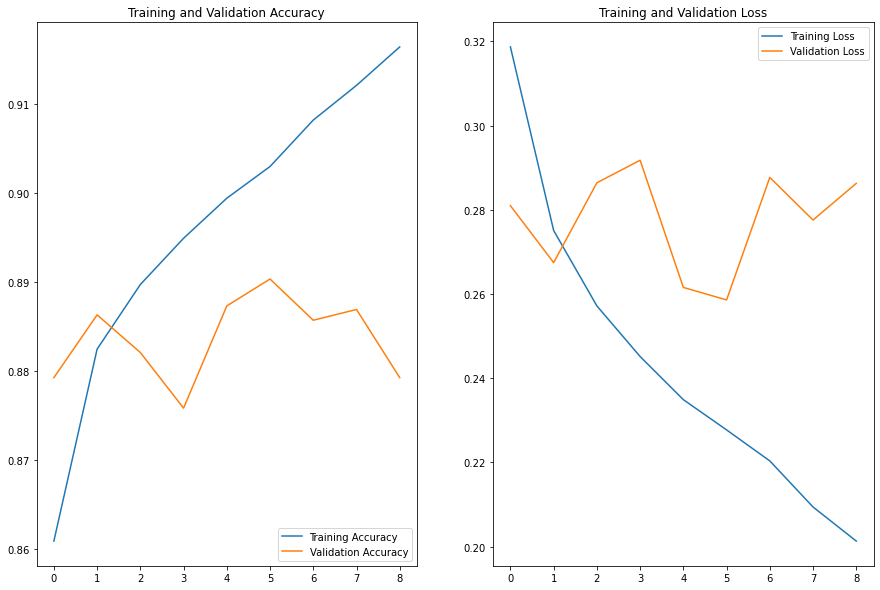

In [16]:
acc, val_acc, loss, val_loss, epochs_range = plot_model_acc_loss(history)

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  Uninfected       0.87      0.94      0.90      1336
 Parasitized       0.94      0.86      0.90      1420

    accuracy                           0.90      2756
   macro avg       0.90      0.90      0.90      2756
weighted avg       0.90      0.90      0.90      2756



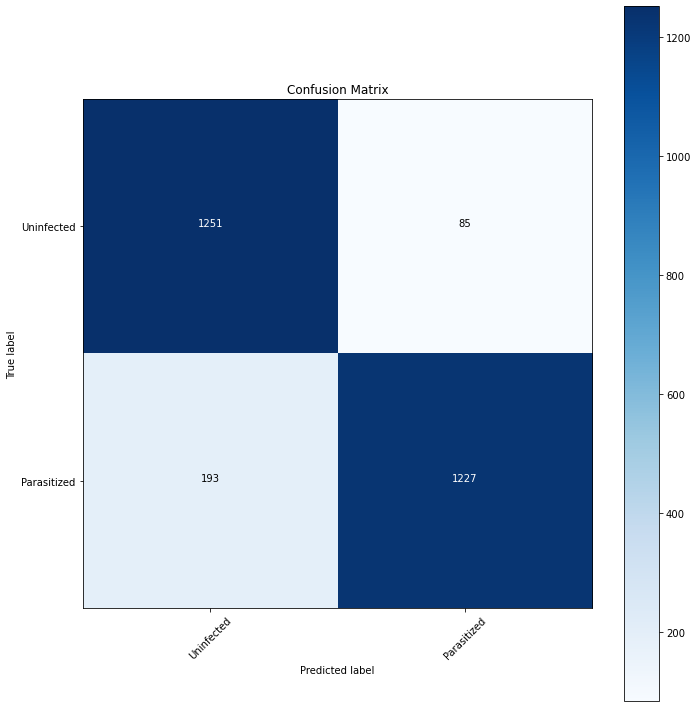

In [17]:
cm = show_model_result(x_test, y_test)

In [18]:
with open('vggnet_result.npy', 'wb') as f:
    np.save(f, acc)
    np.save(f, val_acc)
    np.save(f, loss)
    np.save(f, val_loss)
    np.save(f, epochs_range)
    np.save(f, cm)